# Importing Packages and Config

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from ipywidgets import  fixed
import ipywidgets as widgets
import ipywidgets as interactive
plt.rcParams['figure.figsize'] = [16,8]
from IPython.display import clear_output


#### Some Misc Functions

In [2]:
def fmt(x):
    if x >= 10**6:
        return f'{x/10**6:.1f}M'
    elif x >= 10**3:
        return f'{x/10**3:.1f}K'
    else:
        return f'{x:.0f}'

def convert_from_seconds(sec, to = 'days'):
    sec = sec.total_seconds()
    match to:
        case 'months':
            return sec / 60 / 60 / 24 / 30
        case 'days':
            return sec / 60 / 60 / 24
        case 'hours':
            return sec / 60 / 60
        case 'minutes':
            return sec / 60
        case 'seconds':
            return sec
        case _:
            raise ValueError(f'Unknown unit {to}')

def assign_grouping(value,values):
  for group in values:
    if group in value:
      return group
  return 'Other'

# Importing the dataset

In [3]:
df_orig = pd.read_csv('../data/311.csv', low_memory=False)

In [4]:
df = df_orig.copy(deep=True)

# Convert dates

In [5]:
df['open_dt'] = pd.to_datetime(df['open_dt'],format='%Y-%m-%d %H:%M:%S')
df['sla_target_dt'] = pd.to_datetime(df['sla_target_dt'],format='%Y-%m-%d %H:%M:%S')
df['closed_dt'] = pd.to_datetime(df['closed_dt'],format='%Y-%m-%d %H:%M:%S')

## Add Resolution Time Column

In [6]:
from datetime import timedelta
df['resolution_time'] = df['closed_dt'] - df['open_dt'] # add new column for resolution time
df['resolution_time'].describe()
df.loc[df['resolution_time'] < timedelta(0),'resolution_time'] = timedelta(seconds=0) # replace negative resolution times with 0

## Fix Neighborhood Column

There is a value of ' ' and nan, so for the sake of saving data, we change this value to 'No Neighborhood Data'

In [7]:
df['neighborhood'] = df['neighborhood'].fillna(' ')
# now replace all ' ' values with 'No Neighborhood'
df.loc[df.neighborhood == ' ','neighborhood'] = 'No Neighborhood Data'

#### Some misc variables

In [8]:
year_range = df.open_dt.dt.year.agg(['min','max'])
year_min = year_range['min']
year_max = year_range['max']

# Base Questions

## What is the total volume of requests per year or how many 311 requests is the city receiving per year?

In [9]:
%%html
<style>
/*overwrite hard coded write background by vscode for ipywidges */
.cell-output-ipywidget-background {
   background-color: transparent !important;
}

/*set widget foreground text and color of interactive widget to vs dark theme color */
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

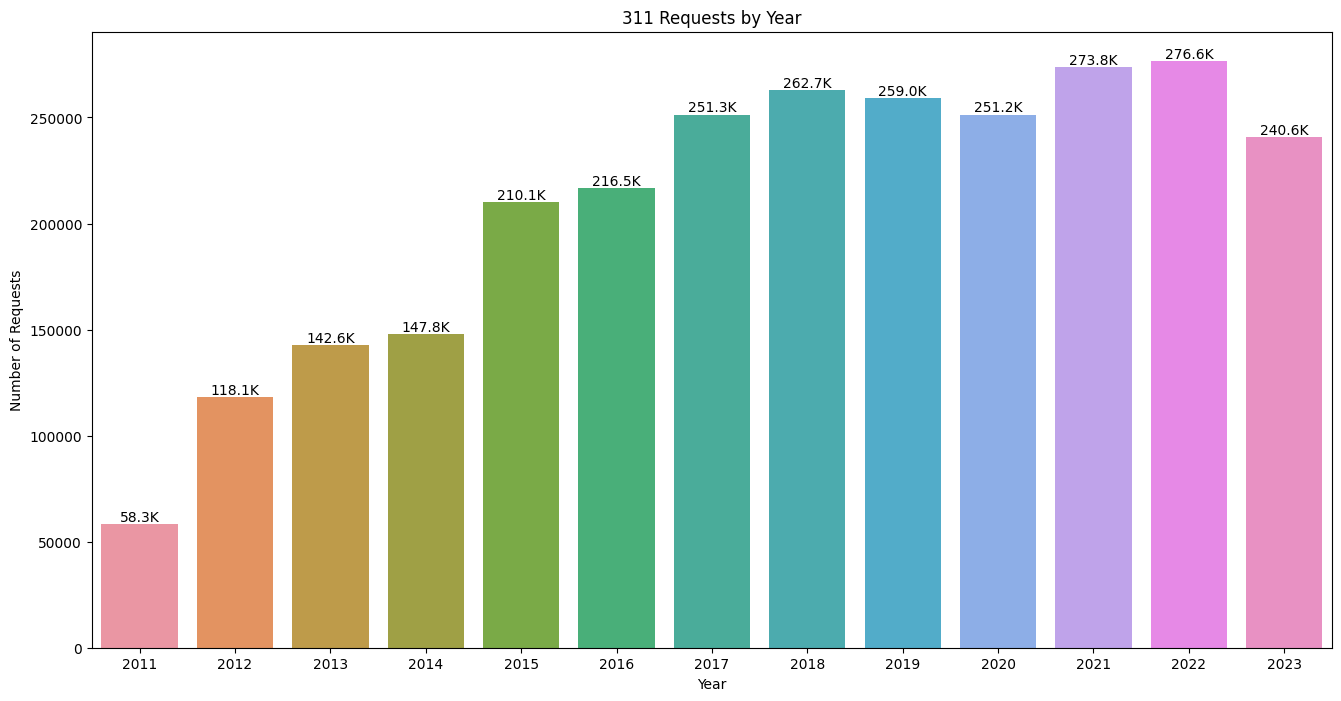

In [10]:
def plot_year_volume():
    fig = sns.countplot(df,x=df['open_dt'].dt.year)
    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')
    fig.set(xlabel='Year', ylabel='Number of Requests')
    plt.title('311 Requests by Year')
    plt.show()

plot_year_volume()

## Which service requests are most common for the city overall AND by NEIGHBORHOOD and how is this changing year over year by SUBJECT (department), REASON,QUEUE?

## Most Common Overall

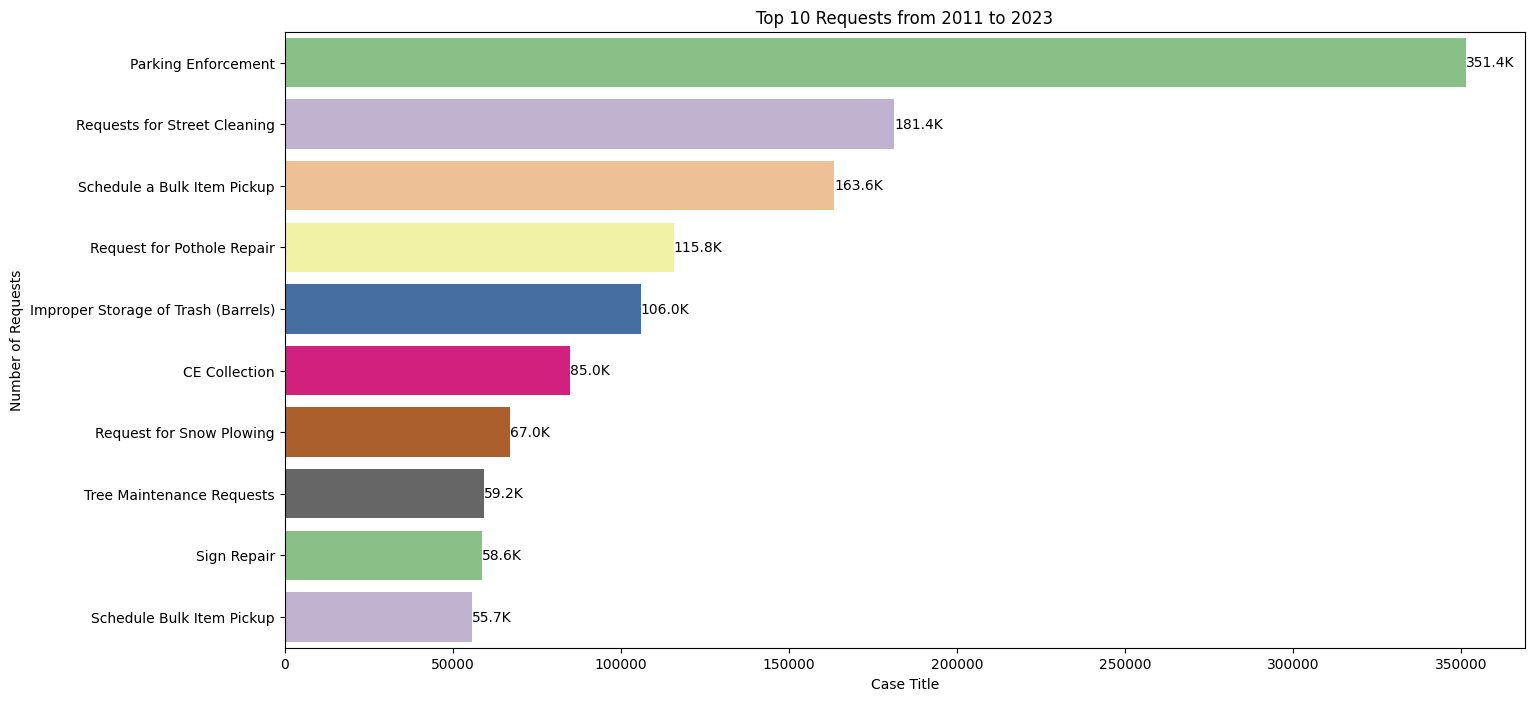

In [11]:
year_slider_most_common = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%'),
    style={'description_width': 'initial'}
)

plot_button_most_common = widgets.Button(
    description='Plot',
    style={'description_width': 'initial'}
)

top_n_most_common = widgets.BoundedIntText(
    value=10,
    min=1,
    max=30,
    step=1,
    description='Top:',
    disabled=False,
    style={'description_width': 'initial'}
)

def plot_most_common():
    years = year_slider_most_common.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]
    n = top_n_most_common.value
    fig = sns.countplot(data = filtered,y = 'case_title',order = filtered.case_title.value_counts().iloc[:n].index, palette = sns.color_palette('Accent'))


    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')
    fig.set(xlabel='Number of Requests', ylabel='Case Title')

    if years[0] == years[1]:
        plt.title(f'Top {n} Requests in {years[0]}')
    else:
        plt.title(f'Top {n} Requests from {years[0]} to {years[1]}')

def button_click_most_common(b):
    clear_output()
    display(widgets.VBox([widgets.HBox([year_slider_most_common,top_n_most_common], layout = widgets.Layout(
        width='80%',
        display='flex',
        flex_flow='row',
        justify_content='space-between',
        align_items='center'
    )),plot_button_most_common]))
    plot_most_common()

plot_button_most_common.on_click(button_click_most_common)
plot_button_most_common.click()

    

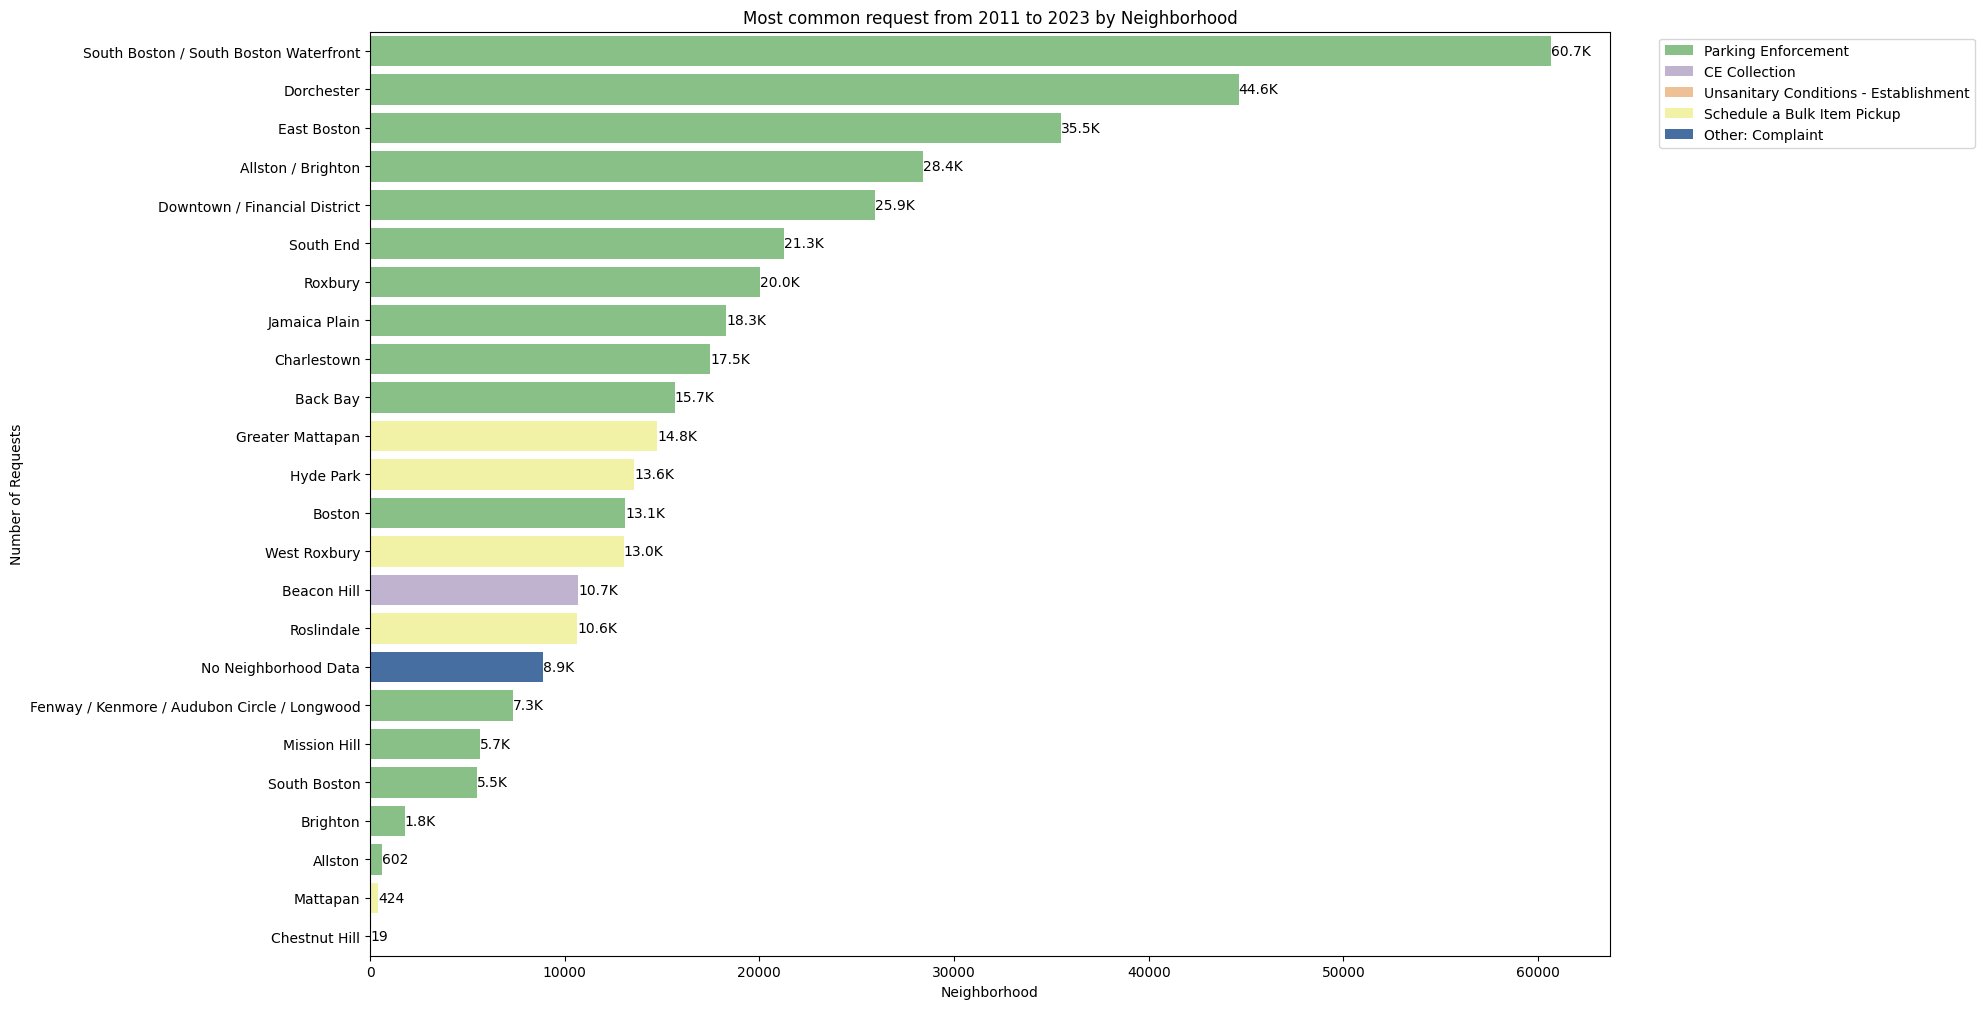

In [12]:
neighborhood_widgets = []

for neighborhood in df['neighborhood'].unique():
    neighborhood = widgets.Checkbox(
        value=True,
        description=neighborhood,
        disabled=False,
        indent=False,
    )

    neighborhood_widgets.append(neighborhood)

neighborhood_box = widgets.VBox(neighborhood_widgets, layout = widgets.Layout(
        width='80%',
        display='grid',
        grid_template_columns='repeat(3, 33%)',
        row_gap='50px',
    ))

toggle_state = True
toggle_all = widgets.Button(
    description='Toggle All',
    style={'description_width': 'initial'}
)



year_slider_most_common_neighborhood = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%'),
    style={'description_width': 'initial'}
)

plot_button_most_common_neighborhood = widgets.Button(
    description='Plot',
    style={'description_width': 'initial'}
)

def plot_most_common_by_neighborhood():
    years = year_slider_most_common_neighborhood.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    neighborhoods = []
    for neighborhood in neighborhood_widgets:
        if neighborhood.value:
            neighborhoods.append(neighborhood.description)

    if len(neighborhoods) == 0:
        print('Please select at least one neighborhood')
        return
    
    if len(neighborhoods) <= 5:
        plt.figure(figsize=(16,8))
    elif len(neighborhoods) <= 10:
        plt.figure(figsize=(16,10))
    else:
        plt.figure(figsize=(16,12))

    filtered = filtered[filtered['neighborhood'].isin(neighborhoods)]

    top_cases_by_neighborhood = (
        filtered.groupby('neighborhood')['case_title']
        .value_counts()
        .groupby(level=0, group_keys=False)
        .nlargest(1)
        .reset_index(name='count')
    )

    pal = sns.color_palette("Accent")
    
    fig = sns.barplot(data = top_cases_by_neighborhood,y = 'neighborhood',x = 'count',hue = 'case_title',palette = pal, dodge=False, order = top_cases_by_neighborhood.sort_values('count',ascending=False).neighborhood)

    for container in fig.containers:
        fig.bar_label(container, fmt=fmt, label_type='edge')

    fig.set(xlabel='Neighborhood', ylabel='Number of Requests')
    fig.legend(loc='upper right', bbox_to_anchor=(1.3, 1), ncol=1)

    if years[0] == years[1]:
        plt.title(f'Most common request in {years[0]} by Neighborhood')
    else:
        plt.title(f'Most common request from {years[0]} to {years[1]} by Neighborhood')

    plt.show()



def toggle_all_click(b):
    global toggle_state
    toggle_state = not toggle_state

    for neighborhood in neighborhood_widgets:
        neighborhood.value = toggle_state

    
toggle_all.on_click(toggle_all_click)

def button_click_most_common_neighborhood(b):
    clear_output(wait=True)

    display(widgets.HBox([widgets.Label('Select Neighborhoods:'),toggle_all], layout = widgets.Layout(
        width='80%',
        display='flex',
        flex_flow='row',
        justify_content='space-between',
        align_items='center'
    )))

    display(neighborhood_box)
    
    display(widgets.VBox([widgets.HBox([year_slider_most_common_neighborhood], layout = widgets.Layout(
        width='80%',
        display='flex',
        flex_flow='row',
        justify_content='space-between',
        align_items='center'
    )),plot_button_most_common_neighborhood]))

    plot_most_common_by_neighborhood()
    

plot_button_most_common_neighborhood.on_click(button_click_most_common_neighborhood)
plot_button_most_common_neighborhood.click()


### Change over years by SUBJECT

In [13]:
%%html
<style>
    .widget-radio-box {
        display: grid;
        grid-template-columns: repeat(3, 1fr);
        grid-gap: 10px;
        align-items: center;
        padding-left: 50px;
    }
    
</style>

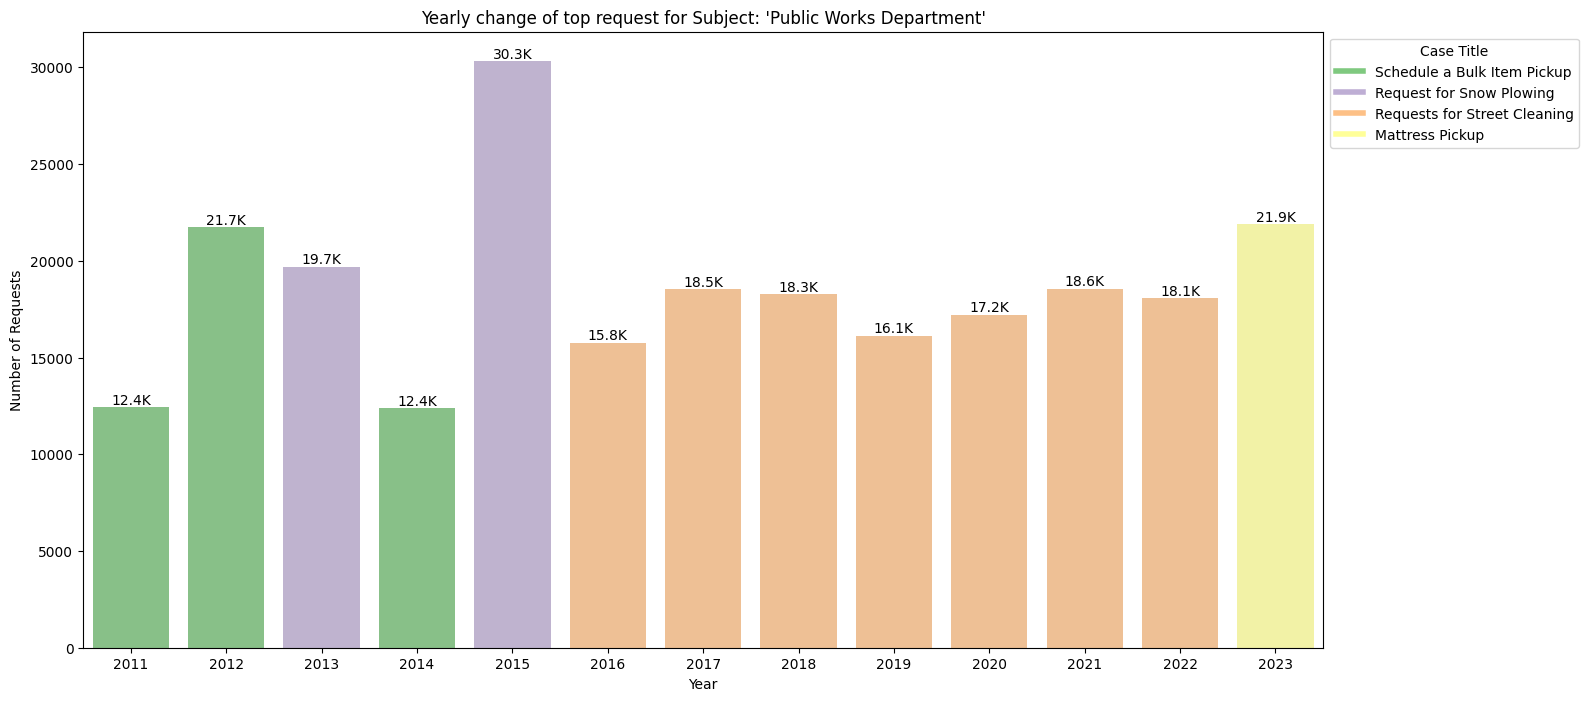

In [14]:
radio_buttons_most_common_subject = widgets.RadioButtons(
    options=df['subject'].unique(),
    description='Subject:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

plot_button_most_common_subject = widgets.Button(
    description='Plot',
    style={'description_width': 'initial'}
)

def plot_most_common_subject():
    subject = radio_buttons_most_common_subject.value
    filtered = df[df.subject == subject]
    
    most_common_for_years = (filtered.groupby(filtered.open_dt.dt.year)['case_title']
                         .value_counts().groupby(level=0).head(1).reset_index(level=1, name='count'))

    # Create a color map for each unique case_title
    unique_titles = most_common_for_years['case_title'].unique()
    color_map = {title: p for title, p in zip(unique_titles, sns.color_palette("Accent", len(unique_titles)))}

    # Plot without hue
    fig = sns.barplot(x=most_common_for_years.index, y=most_common_for_years['count'], palette=[color_map[title] for title in most_common_for_years['case_title']])

    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')

    plt.legend(handles=[
        plt.Line2D([0], [0], color=color_map[title], lw=4, label=title, c=color_map[title]) for title in unique_titles
    ], title='Case Title', bbox_to_anchor=(1, 1), loc='upper left')

    fig.set(xlabel='Year', ylabel='Number of Requests')
    plt.title(f'Yearly change of top request for Subject: \'{subject}\'')


def button_click_most_common_subject(b):
    clear_output()
    display(widgets.VBox([radio_buttons_most_common_subject,plot_button_most_common_subject]))
    plot_most_common_subject()

plot_button_most_common_subject.on_click(button_click_most_common_subject)
plot_button_most_common_subject.click()

### Change over years by REASON

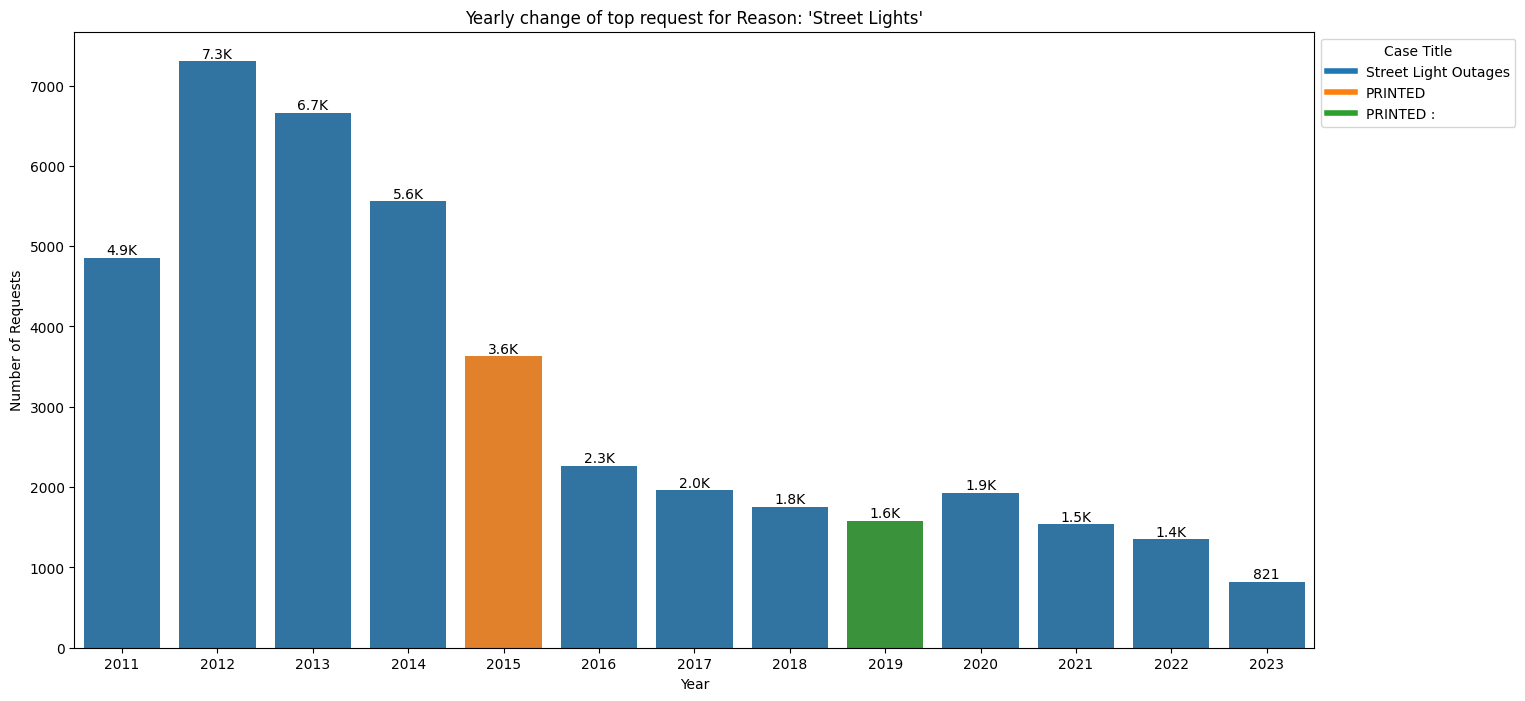

In [15]:
radio_buttons_most_common_reason = widgets.RadioButtons(
    options=df['reason'].unique(),
    description='Reason:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='100%')
)

plot_button_most_common_reason = widgets.Button(
    description='Plot',
    style={'description_width': 'initial'},
    layout=widgets.Layout(margin='50px 0 0 0')
)

def plot_most_common_reason():
    reason = radio_buttons_most_common_reason.value
    filtered = df[df.reason == reason]
    
    most_common_for_years = (filtered.groupby(filtered.open_dt.dt.year)['case_title']
                         .value_counts().groupby(level=0).head(1).reset_index(level=1, name='count'))

    # Create a color map for each unique case_title
    unique_titles = most_common_for_years['case_title'].unique()
    color_map = {title: p for title, p in zip(unique_titles, sns.color_palette("tab10", len(unique_titles)))}

    fig = sns.barplot(x=most_common_for_years.index, y=most_common_for_years['count'], palette=[color_map[title] for title in most_common_for_years['case_title']])

    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')

    plt.legend(handles=[
        plt.Line2D([0], [0], color=color_map[title], lw=4, label=title, c=color_map[title]) for title in unique_titles
    ], title='Case Title', bbox_to_anchor=(1, 1), loc='upper left')

    fig.set(xlabel='Year', ylabel='Number of Requests')
    plt.title(f'Yearly change of top request for Reason: \'{reason}\'')


def button_click_most_common_reason(b):
    clear_output()
    display(widgets.VBox([radio_buttons_most_common_reason,plot_button_most_common_reason]))
    plot_most_common_reason()

plot_button_most_common_reason.on_click(button_click_most_common_reason)
plot_button_most_common_reason.click()

### Change over years by QUEUE

In [16]:

options=['PWDx','BTDT','PARK','INFO','ISD','Other']
department_radio_buttons_yearly_queue = widgets.RadioButtons(
    options=options,
    description='Department:',
)
queue_options = {}

queue_options['PWDx'] = widgets.Dropdown(
    options=['Recycling','District','Street Light','Highway','Snow','Repair','Complaint','Litter Basket','Engineering','Other'],
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

queue_options['BTDT'] = widgets.Dropdown(
    options=df[df.department == 'BTDT']['queue'].unique(),
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

queue_options['PARK'] = widgets.Dropdown(
    options=df[df.department == 'PARK']['queue'].unique(),
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

queue_options['INFO'] = widgets.Dropdown(
    options=df[df.department == 'INFO']['queue'].unique(),
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

queue_options['ISD'] = widgets.Dropdown(
    options=df[df.department == 'ISD']['queue'].unique(),
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

queue_options['Other'] = widgets.Dropdown(
    options=df[~df.department.isin(['PWDx','BTDT','PARK','INFO','ISD'])]['queue'].unique(),
    description='Queue:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='30rem')
)

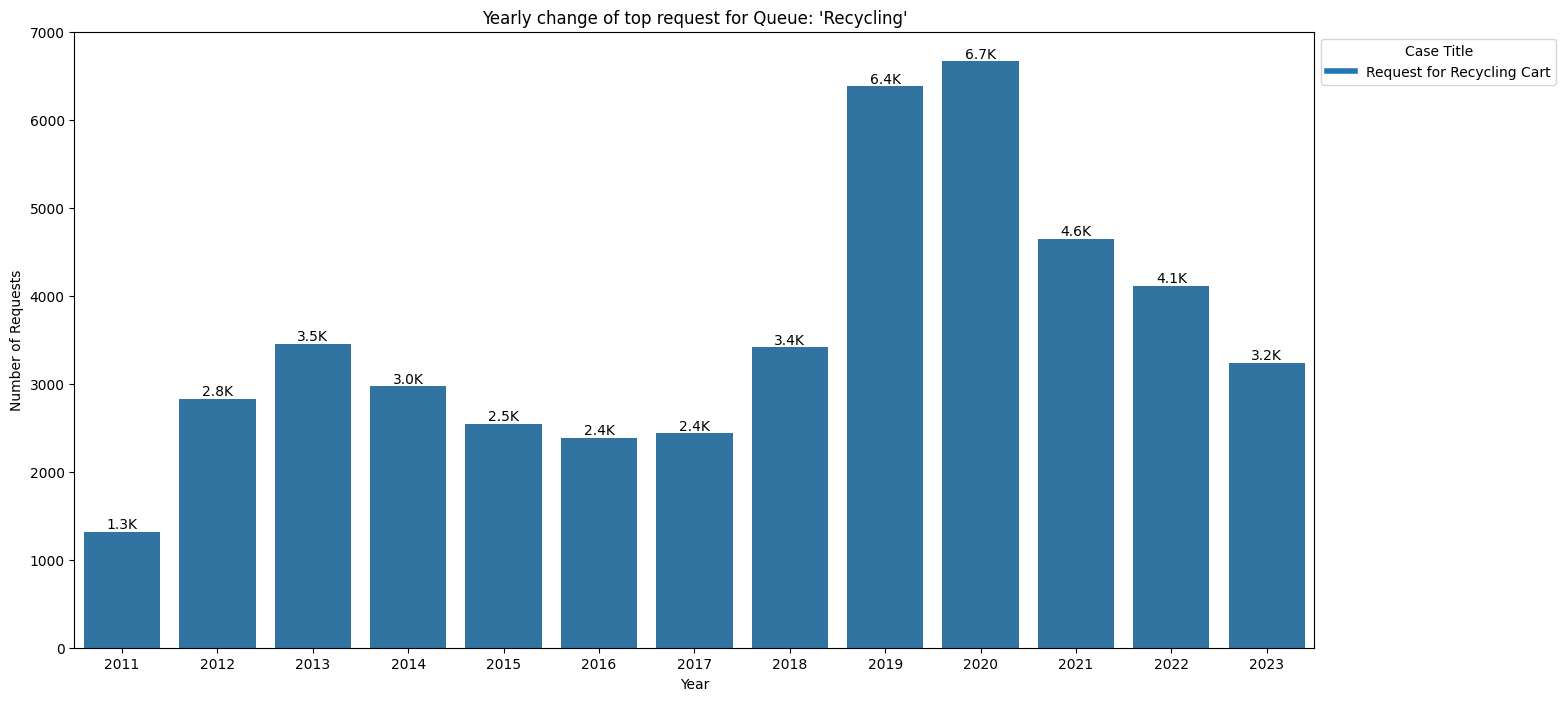

In [17]:
department_tab = widgets.Tab()
plot_button_department_queue = widgets.Button(
    description='Plot',
    style={'description_width': 'initial'},
    button_style='success'
)

children_as_widgets = [queue_options[option] for option in options]
children = [widgets.HBox([queue_options[option]]) for option in options]
department_tab.children = [widgets.HBox([child,plot_button_department_queue], layout=widgets.Layout(justify_content='space-between')) for child in children]

for i,option in enumerate(options):
    department_tab.set_title(i,option)

display(widgets.VBox([department_tab]))

def plot_department_queue():
    def plot_pwd():
        filtered = df[df.department == 'PWDx'].copy(deep=True)
        groups = ['Recycling','District','Street Light','Highway','Snow','Repair','Complaint','Litter Basket','Engineering']
        
        filtered['queue'] = filtered['queue'].apply(lambda x: assign_grouping(x,groups))
        picked_queue = children_as_widgets[0].value
        filtered = filtered[filtered.queue == picked_queue]

        most_common_for_years = (filtered.groupby(filtered.open_dt.dt.year)['case_title'].value_counts().groupby(level=0).head(1).reset_index(level=1, name='count'))

        # Create a color map for each unique case_title
        unique_titles = most_common_for_years['case_title'].unique()
        color_map = {title: p for title, p in zip(unique_titles, sns.color_palette("tab10", len(unique_titles)))}
        
        fig = sns.barplot(x=most_common_for_years.index, y=most_common_for_years['count'], palette=[color_map[title] for title in most_common_for_years['case_title']])
        fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')

        plt.legend(handles=[
            plt.Line2D([0], [0], color=color_map[title], lw=4, label=title, c=color_map[title]) for title in unique_titles
        ], title='Case Title', bbox_to_anchor=(1, 1), loc='upper left')

        fig.set(xlabel='Year', ylabel='Number of Requests')
        plt.title(f'Yearly change of top request for Queue: \'{picked_queue}\'')
        plt.show()
        
    current_tab = department_tab.selected_index

    if current_tab == 0: #PWDx
        plot_pwd()
        return
    else:
        filtered = df[df.department == options[current_tab]]

    selected_queue = children_as_widgets[current_tab].value
    filtered = df[df.queue == selected_queue]

    most_common_for_years = (filtered.groupby(filtered.open_dt.dt.year)['case_title'].value_counts().groupby(level=0).head(1).reset_index(level=1, name='count'))

    # Create a color map for each unique case_title
    unique_titles = most_common_for_years['case_title'].unique()
    color_map = {title: p for title, p in zip(unique_titles, sns.color_palette("tab10", len(unique_titles)))}

    fig = sns.barplot(x=most_common_for_years.index, y=most_common_for_years['count'], palette=[color_map[title] for title in most_common_for_years['case_title']])
    fig.bar_label(fig.containers[0], fmt=fmt, label_type='edge')

    plt.legend(handles=[
        plt.Line2D([0], [0], color=color_map[title], lw=4, label=title, c=color_map[title]) for title in unique_titles
    ], title='Case Title', bbox_to_anchor=(1, 1), loc='upper left')

    fig.set(xlabel='Year', ylabel='Number of Requests')
    plt.title(f'Yearly change of top request for Queue: \'{selected_queue}\'')
    plt.show()
    



def button_click_department_queue(b):
    clear_output(wait=True)
    display(widgets.VBox([department_tab]))
    plot_department_queue()

plot_button_department_queue.on_click(button_click_department_queue)
plot_button_department_queue.click()

## How is the case volume changing by submission channel SOURCE?

IntRangeSlider(value=(2011, 2023), description='Years:', layout=Layout(width='40%'), max=2023, min=2011)

Button(description='Plot', style=ButtonStyle())

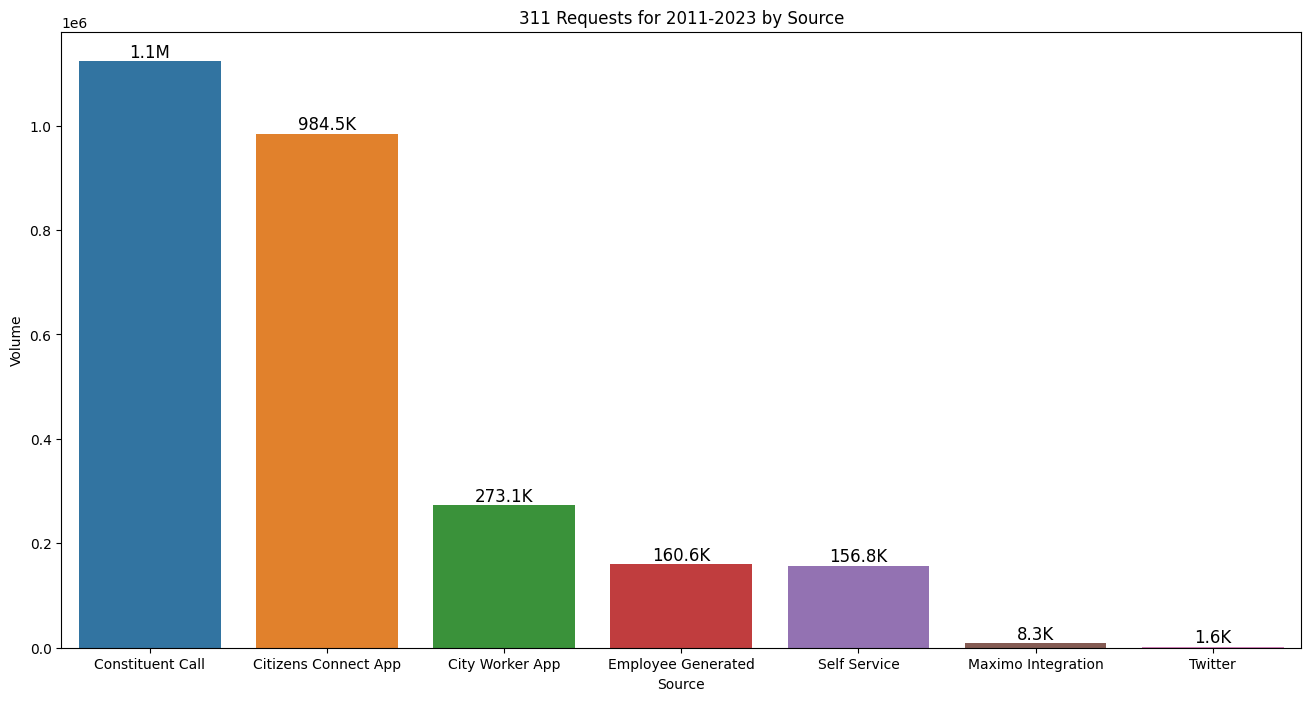

In [18]:
year_slider_source = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_source = widgets.Button(description='Plot')


def plot_by_source():
    years = year_slider_source.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    fig = sns.countplot(data=filtered, x='source',order=filtered['source'].value_counts().index)
    
    fig.bar_label(fig.containers[0],fmt = fmt, fontsize=12)
    fig.set(xlabel='Source',ylabel='Volume')

    if years[0] == years[1]:
        plt.title(f'311 Requests for {years[0]} by Source')
    else:
        plt.title(f'311 Requests for {years[0]}-{years[1]} by Source')

    plt.show()


def button_click_source(b):
    clear_output(wait=True)
    display(year_slider_source)
    display(plot_button_source)
    plot_by_source()
    
plot_button_source.on_click(button_click_source)
plot_button_source.click()

## What is the average # of daily contacts by year?

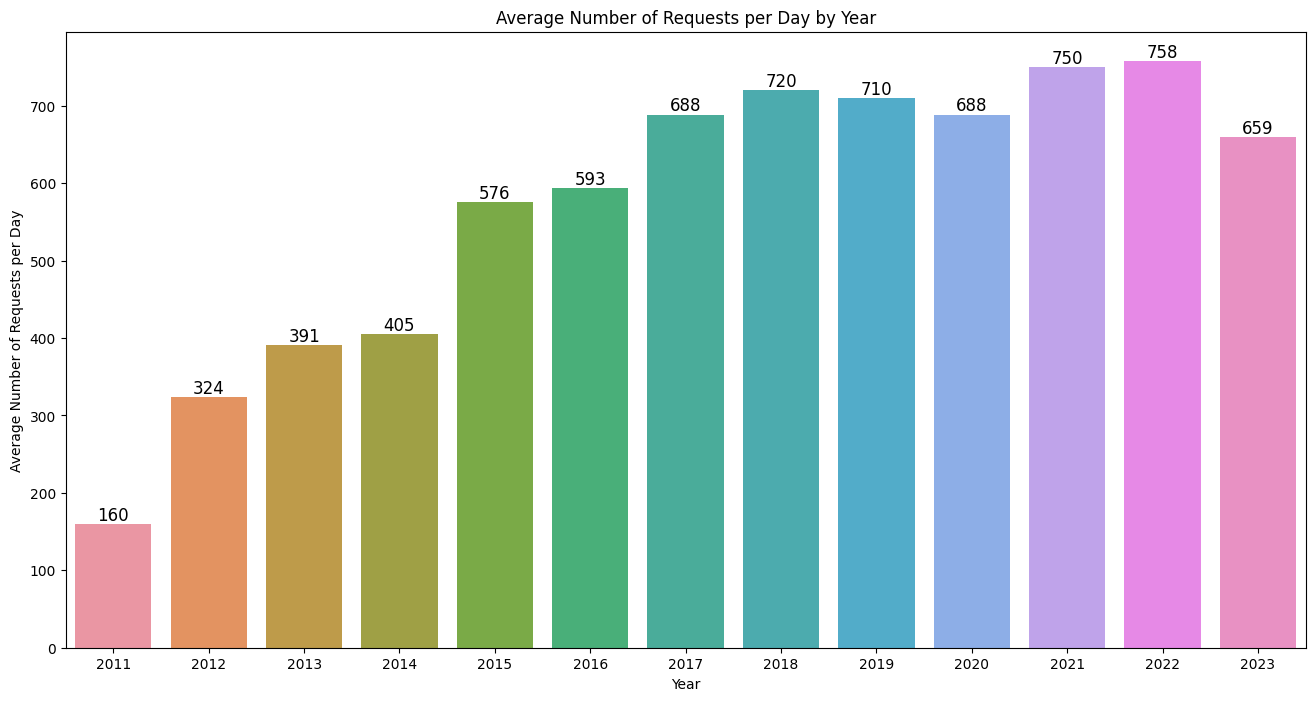

In [19]:
def plot_day_average():
    averages = df.groupby(df['open_dt'].dt.year)['case_enquiry_id'].count() / 365
    plt.title('Average Number of Requests per Day by Year')
    fig = sns.barplot(x=averages.index,y=averages)
    fig.bar_label(fig.containers[0], fmt=fmt, fontsize=12)
    fig.set(xlabel='Year',ylabel='Average Number of Requests per Day')
    plt.show()

plot_day_average()

## Volume of top 5 request types (TYPE)

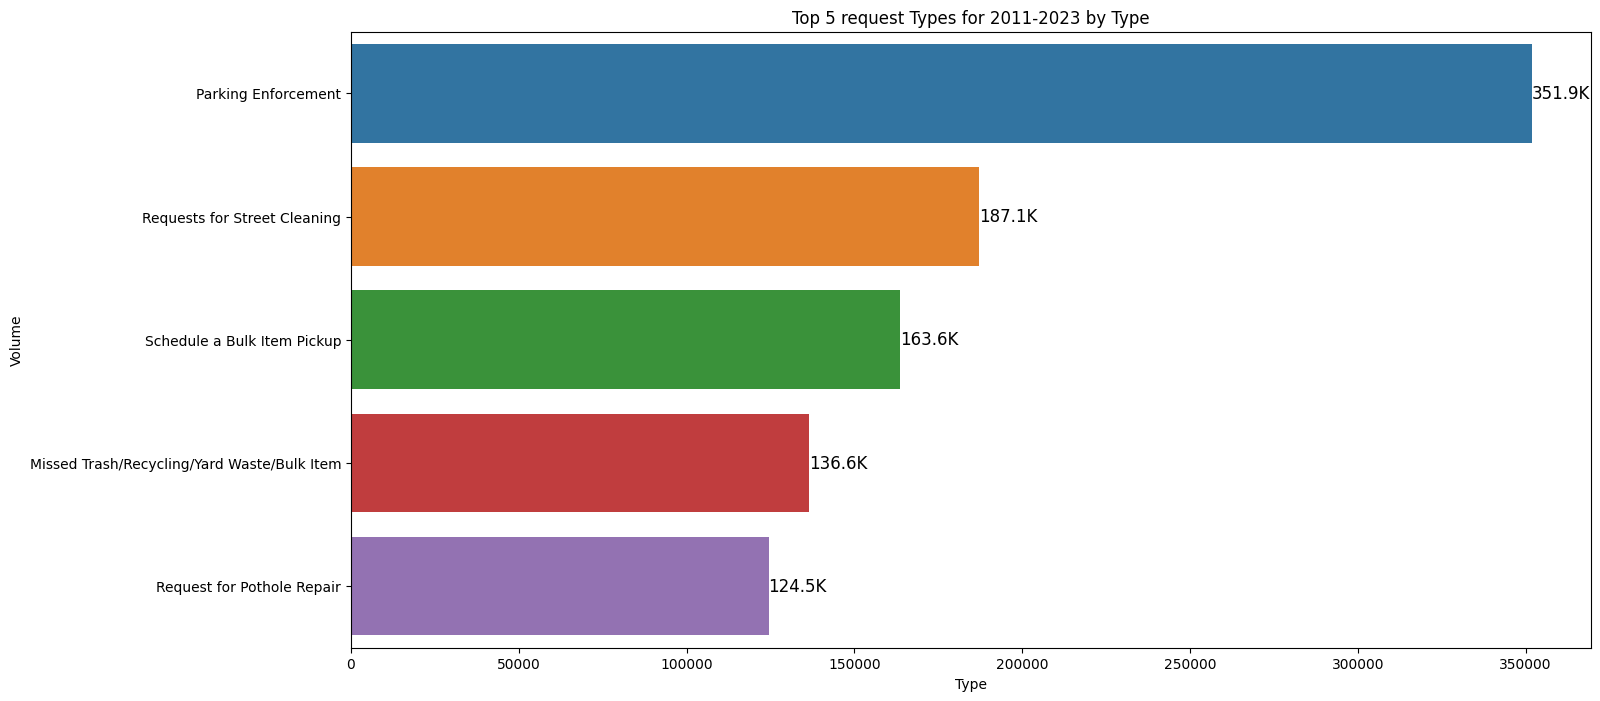

In [20]:
year_slider_type = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_type = widgets.Button(description='Plot')

def plot_type():
    years = year_slider_type.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    if years[0]==years[1]:
        plt.title(f'Top 5 request Types for {years[0]} by Type')
    else:
        plt.title(f'Top 5 request Types for {years[0]}-{years[1]} by Type')

    fig = sns.countplot(data=filtered,y='type',order=filtered['type'].value_counts().iloc[:5].index)

    fig.bar_label(fig.containers[0],fmt=fmt,fontsize=12)
    fig.set(xlabel='Type',ylabel='Volume')

    plt.show()


def button_click_type(b):
    clear_output(wait=True)
    display(widgets.HBox([year_slider_type,plot_button_type], layout = widgets.Layout(width = '80%', display='flex', flex_flow='row', justify_content='space-between', align_items='center')))
    plot_type()

plot_button_type.on_click(button_click_type)
plot_button_type.click()

## Average goal resolution time by QUEUE



There are 181 different queues, so we have to split them into groups.


First, we will split groups by department, then group inside if needed.

These are the groups we end up with:

1. PWD Group
2.  BTDT Group
3.  ISD Group
4.  INFO Group
5.  PARK Group
6.  Other Group


Since PWD Group has 70 unique queues, we applied custom grouping

1. Engineering : 
2. Repair
3. Highway
4. Snow
5. Street Light
6. Complaint
7. Recycling
8. Other
9. Litter Basket
10. District


RadioButtons(layout=Layout(display='flex', flex_flow='row'), options=('PWDx', 'BTDT', 'PARK', 'INFO', 'ISD', '…

Button(description='Plot', style=ButtonStyle())

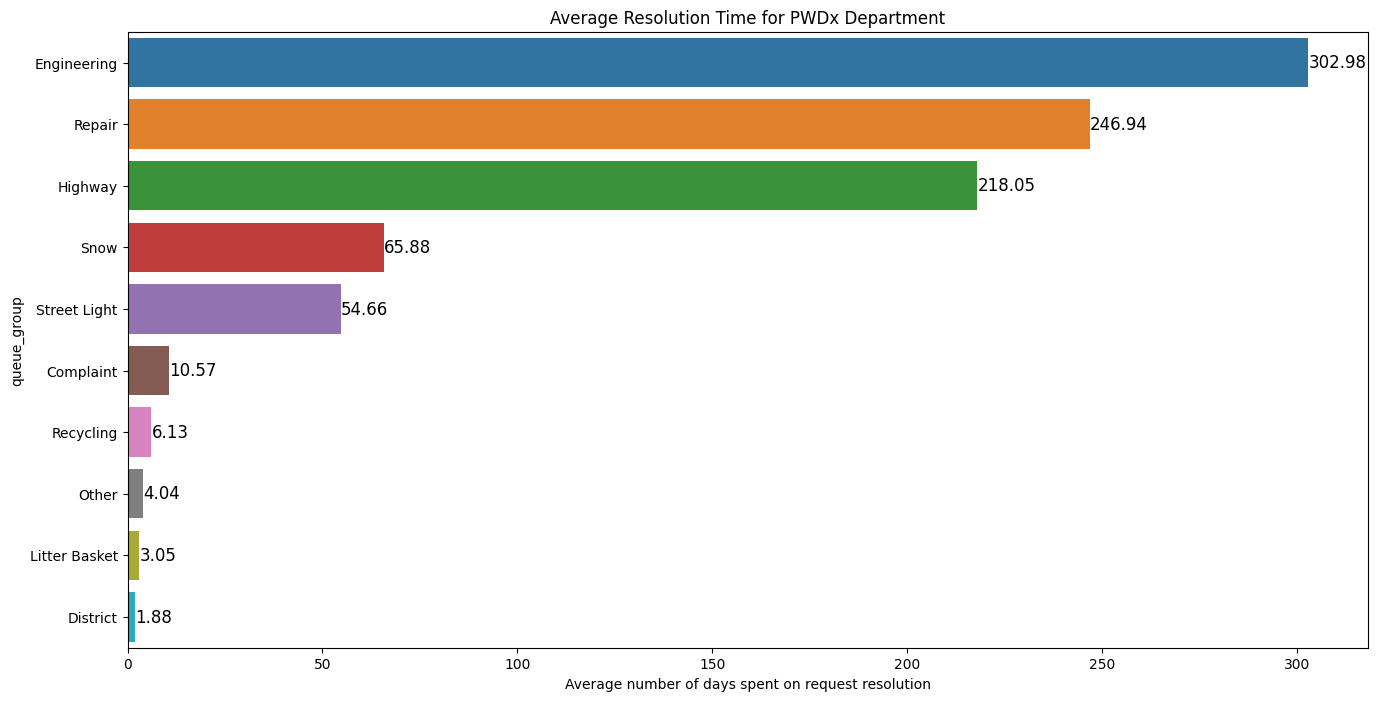

In [21]:
department_radio_buttons = widgets.RadioButtons(
    options = ['PWDx','BTDT','PARK','INFO','ISD','Other'],
    layout=widgets.Layout(display='flex',flex_flow='row')
)

plot_button_art = widgets.Button(description='Plot')

def plot_art():
    def plot_pwd():
        plt.title(f'311 Requests by Queue for PWDx Department')
        group = ['Recycling','District','Street Light','Highway','Snow','Repair','Complaint','Litter Basket','Engineering']
        only_department_group = df.loc[df['department'] == department].copy(deep=True)
        only_department_group['queue_group'] = only_department_group['queue'].apply(lambda entry: assign_grouping(entry,group))
        average_resolution_times = only_department_group.groupby('queue_group')['resolution_time'].mean().reset_index()

        fig = sns.barplot(average_resolution_times,y='queue_group',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue_group'])
        plt.title(f'Average Resolution Time for {department} Department')
        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    def plot_department(departments):
        average_resolution_times = df.loc[df['department'].isin(departments)].groupby('queue')['resolution_time'].mean().reset_index()
        fig = sns.barplot(average_resolution_times, y='queue',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue'])
        plt.title('Average Resolution Time for BTDT Department')
        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    department = department_radio_buttons.value
    
    match department:
        case 'PWDx':
            plot_pwd()
        case 'Other':
            plot_department(df[~df['department'].isin(['PWDx','BTDT','PARK','INFO','ISD'])]['department'].unique())
        case _:
            plot_department([department])

def on_button_clicked(b = None):
    clear_output(wait=True)
    display(department_radio_buttons)
    display(plot_button_art)
    plot_art()

plot_button_art.on_click(on_button_clicked)
plot_button_art.click()

## Average goal resolution time by QUEUE and neighborhood

Button(description='Plot', style=ButtonStyle())

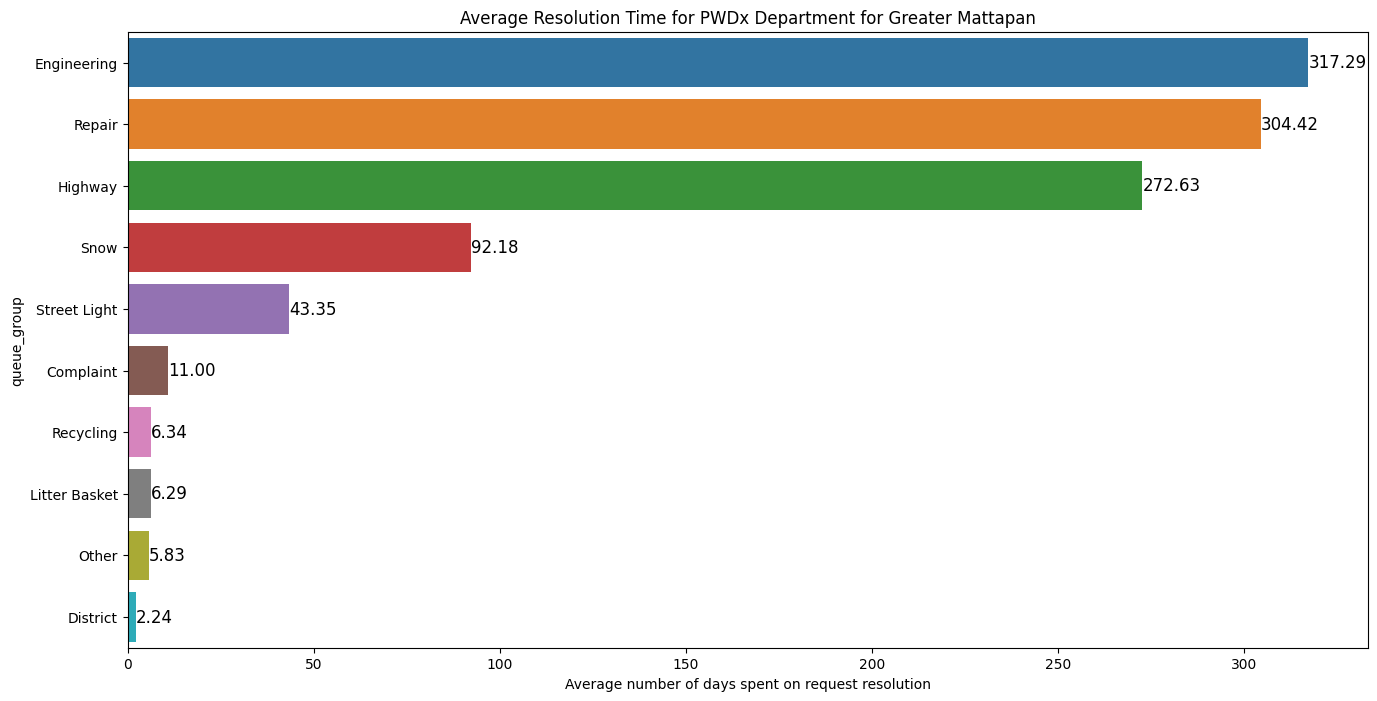

In [22]:
neighborhood_dropwdown = widgets.Dropdown(
    options = df['neighborhood'].unique(),
    layout=widgets.Layout(display='flex',flex_flow='row'),
)

department_radio_buttons_neighborhood = widgets.RadioButtons(
    options = ['PWDx','BTDT','PARK','INFO','ISD','Other'],
    layout=widgets.Layout(display='flex',flex_flow='row'),
)

plot_button_neighborhood_art = widgets.Button(description='Plot')

def plot_neighborhood_art():
    def plot_pwd():
        plt.title(f'311 Requests by Queue for PWDx Department')
        group = ['Recycling','District','Street Light','Highway','Snow','Repair','Complaint','Litter Basket','Engineering']
        only_department_group = df.loc[(df['department'] == department) & (df['neighborhood'] == neighborhood_dropwdown.value)].copy(deep=True)
        only_department_group['queue_group'] = only_department_group['queue'].apply(lambda entry: assign_grouping(entry,group))
        average_resolution_times = only_department_group.groupby('queue_group')['resolution_time'].mean().reset_index()

        fig = sns.barplot(average_resolution_times,y='queue_group',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue_group'])
        plt.title(f'Average Resolution Time for {department} Department for {neighborhood_dropwdown.value}')
        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    def plot_department(departments):
        average_resolution_times = df.loc[(df['department'].isin(departments)) & (df['neighborhood'] == neighborhood_dropwdown.value)].groupby('queue')['resolution_time'].mean().reset_index()
        fig = sns.barplot(average_resolution_times, y='queue',x=average_resolution_times['resolution_time'].apply(convert_from_seconds),order=average_resolution_times.sort_values(by='resolution_time',ascending=False)['queue'])
        
        if len(departments) == 1:
            plt.title(f'Average Resolution Time for {departments[0]} Department for {neighborhood_dropwdown.value}')
        else:
            plt.title('Average Resolution Time for Other Departments for {neighborhood_dropwdown.value}')


        fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
        fig.set(xlabel='Average number of days spent on request resolution')
        plt.show()
    
    department = department_radio_buttons_neighborhood.value
    
    match department:
        case 'PWDx':
            plot_pwd()
        case 'Other':
            plot_department(df[~df['department'].isin(['PWDx','BTDT','PARK','INFO','ISD'])]['department'].unique())
        case _:
            plot_department([department])


def on_button_clicked_neighborhood(b = None):
    clear_output(wait=True)
    hbox_neighborhood = widgets.HBox([widgets.Label('Neighborhood:'),neighborhood_dropwdown])
    display(hbox_neighborhood)
    
    hbox_department = widgets.HBox([widgets.Label('Department:'),department_radio_buttons_neighborhood])
    display(hbox_department)

    display(plot_button_neighborhood_art)
    plot_neighborhood_art()

plot_button_neighborhood_art.on_click(on_button_clicked_neighborhood)
plot_button_neighborhood_art.click()


## What % of service requests are closed (CLOSED_DT or CASE_STATUS) vs. no data (CASE_STATUS = null) vs. unresolved (CASE_STATUS = open)?

IntRangeSlider(value=(2011, 2023), description='Years:', layout=Layout(width='40%'), max=2023, min=2011)

Button(description='Plot', style=ButtonStyle())

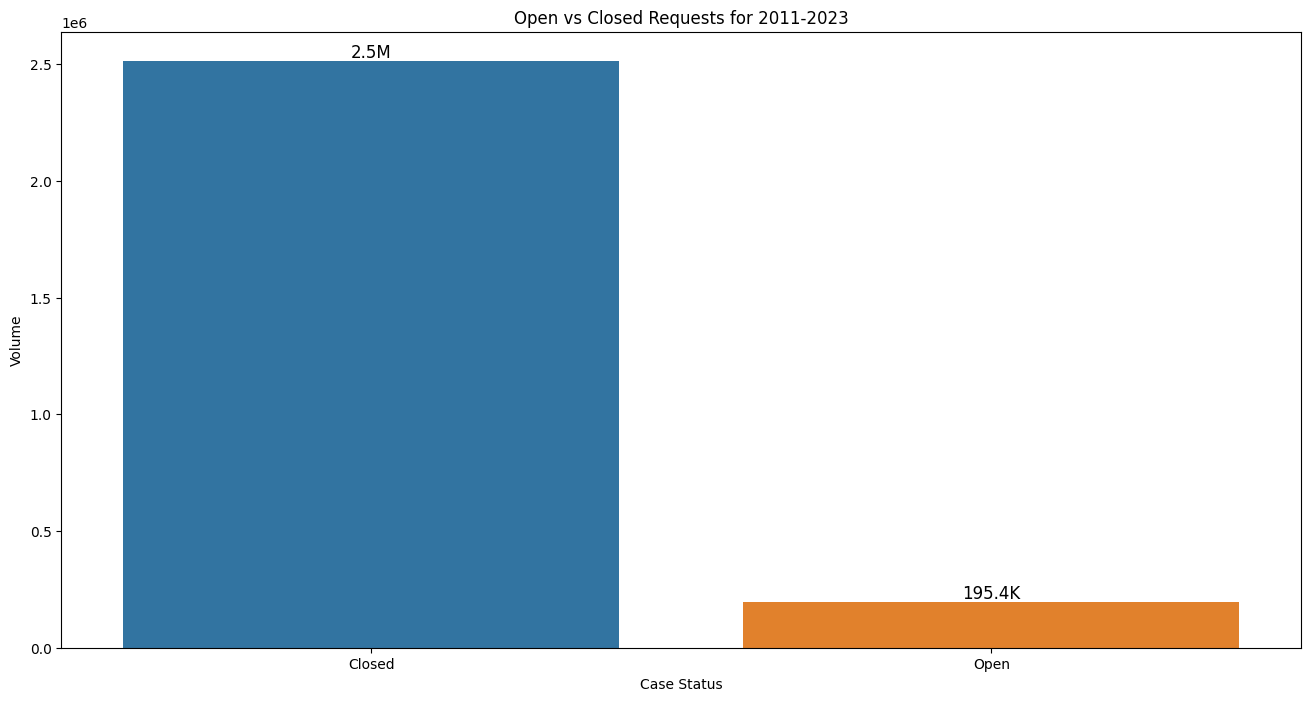

In [23]:
year_slider_case_status = widgets.IntRangeSlider(
    value=[year_min,year_max],
    min=year_min,
    max=year_max,
    step=1,
    description='Years:',
    layout=widgets.Layout(width='40%')
)

plot_button_case_status = widgets.Button(description='Plot')


def plot_case_status():
    years = year_slider_case_status.value
    filtered = df[df.open_dt.dt.year.between(years[0],years[1])]

    if years[0]==years[1]:
        plt.title(f'Open vs Closed Requests for {years[0]}')
    else:
        plt.title(f'Open vs Closed Requests for {years[0]}-{years[1]}')

    fig = sns.countplot(data=filtered,x='case_status',order=filtered['case_status'].value_counts().index)

    fig.bar_label(fig.containers[0],fmt=fmt,fontsize=12)
    fig.set(xlabel='Case Status',ylabel='Volume')

    plt.show()


def button_click_case_status(b):
    clear_output(wait=True)
    display(year_slider_case_status)
    display(plot_button_case_status)
    plot_case_status()

plot_button_case_status.on_click(button_click_case_status)
plot_button_case_status.click()

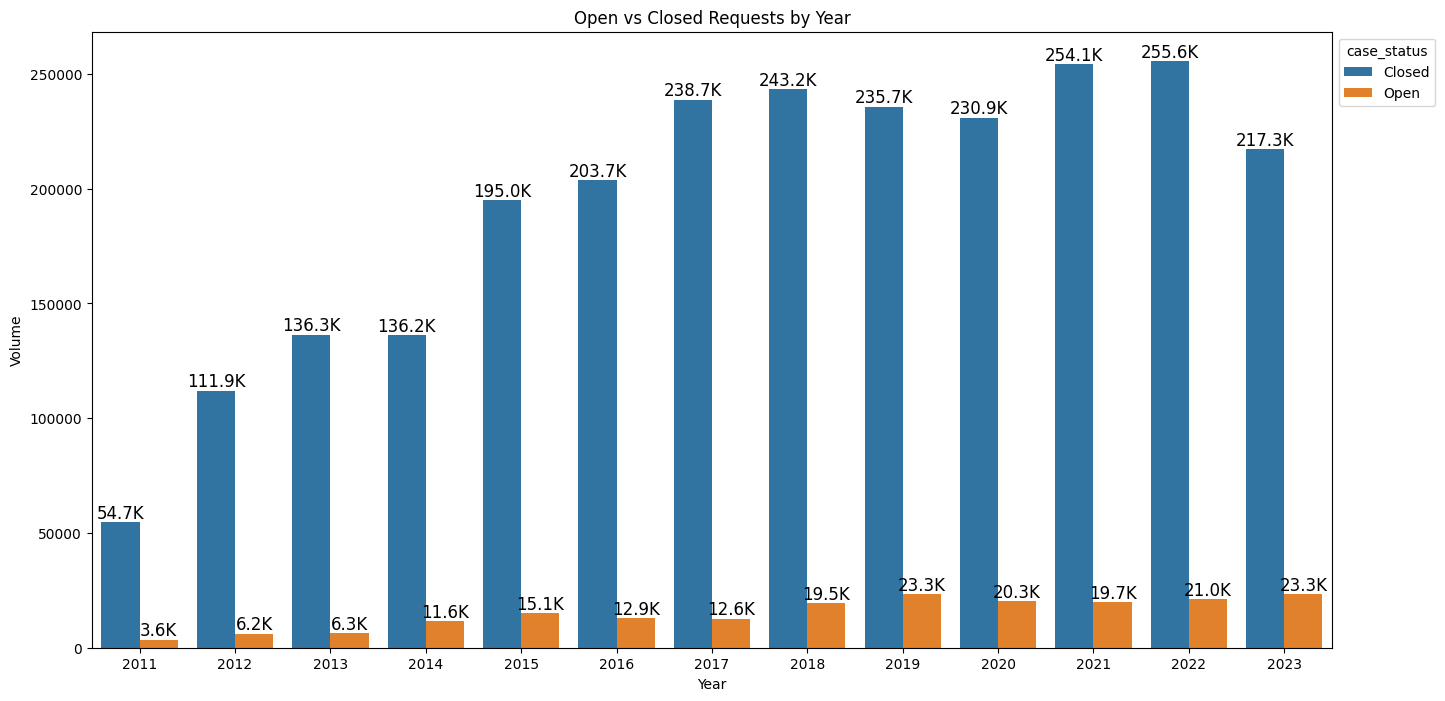

In [24]:
fig = sns.countplot(data=df,x=df.open_dt.dt.year,hue='case_status')
sns.move_legend(fig,'upper left',bbox_to_anchor=(1,1))
fig.bar_label(fig.containers[0],fmt=fmt,fontsize=12)
fig.bar_label(fig.containers[1],fmt=fmt,fontsize=12)
fig.set(xlabel='Year',ylabel='Volume')
plt.title('Open vs Closed Requests by Year')
plt.show()

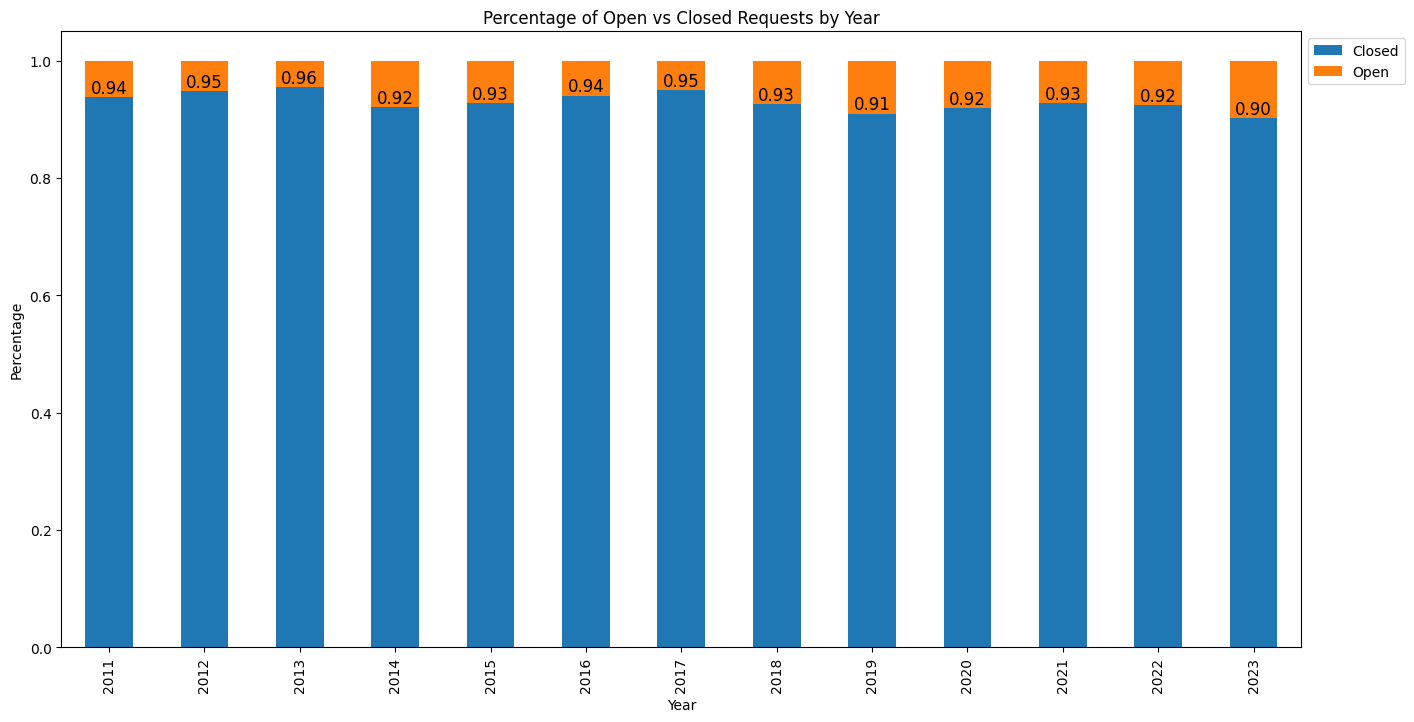

In [25]:
fig = df.groupby(df['open_dt'].dt.year)['case_status'].value_counts(normalize=True).unstack().plot(kind='bar',stacked=True)
fig.set(xlabel='Year',ylabel='Percentage')
fig.bar_label(fig.containers[0],fmt='%.2f',fontsize=12)
plt.title('Percentage of Open vs Closed Requests by Year')
plt.legend(bbox_to_anchor=(1,1))
plt.show()
